### Estudo de Correlação entre Temperatura e Cobertura Vegetal

Este Jupyter Notebook faz parte do módulo de estudo de correlação do projeto PRECORSIA.  
Ele se concentra na análise da correlação entre a temperatura e a cobertura vegetal.

#### Como Utilizar Este Notebook

1. Faça uma cópia deste notebook para o seu ambiente de desenvolvimento.

2. Certifique-se de que você tem todas as dependências necessárias instaladas. Você pode fazê-lo executando o seguinte comando em seu ambiente:

        `pip install numpy pandas matplotlib earthengine-api geemap --upgrade`

3. Execute cada célula do notebook sequencialmente para realizar a análise. Certifique-se de ler e entender cada passo, e ajuste o código, conforme necessário, para atender aos seus requisitos específicos.

4. Se você desejar contribuir com melhorias ou adicionar novas análises, siga as diretrizes no README do sub-módulo para contribuições.  
Você pode criar um novo notebook ou fazer modificações neste, se necessário.

#### Sobre a autorização para utilizar os serviços Google Earth Engine

Sempre que inicializar a aplicação, será solicitado acesso ao serviço GEE através da sua conta google pessoal.  
Para prover acesso e utilizar a API, relize a autorização executando o código abaixo:
```python
import ee
ee.Authenticate()
ee.Initialize()
```
Você será direcionado(a) à uma página WEB, onde será requisitado permissões de acesso.  

> Granting permission. This creates a web application definition controlled by your project provided above. After you click Generate Token, Google will ask for your permission to grant the application access to your data. See details in the step-by-step guide.

> Expiry period. The granted permissions will expire in a week, after which you'll need to call ee.Authenticate() again.

> Revoking permissions. You can view all applications connected to your account, and revoke permissions if needed, on https://myaccount.google.com/permissions. Search for "Earth Engine Notebook Client" to find the application defined by this page.

> Technical details. The web application is defined by a development-mode "OAuth2 Client" on your specified project, which you can manage on the Google Cloud Console.

In [ ]:
# Importing GEE dependencies
import geemap.core as geemap
import ee

# Importing analytical tools
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Execute only once per session
ee.Initialize()

In [ ]:
# LIMITS
img_list_amount = 100
time_round = 8 # 8

In [127]:
# Filter region and date to limit queries
START = ee.Date('2023-01-01')
END = START.advance(365, 'day')

coords = [16.0569, 51.6608]
region = ee.Geometry.Point(coords)

filter = ee.Filter.And(
    ee.Filter.bounds(region),
    ee.Filter.date(START, END),
)

In [128]:
# Get a DYNAMICWORLD/V1 dataset's image list
DWV1_image_collection = ee.ImageCollection(
    'GOOGLE/DYNAMICWORLD/V1').filter(filter)
DWV1_image_coll_list = DWV1_image_collection.toList(img_list_amount)

# Get the time_start and id propertie
DWV1_image_time_list = DWV1_image_coll_list.map(lambda img: ee.Dictionary(
    {'id': ee.Image(img).id(), 'time_start': ee.Image(img).get('system:time_start')})).getInfo()

In [129]:
# Get a JAXA/GCOM-C/L3/LAND/LST/V3 dataset's image list
LSTV3_image_collection = ee.ImageCollection(
    'JAXA/GCOM-C/L3/LAND/LST/V3').filter(filter)
LSTV3_image_coll_list = LSTV3_image_collection.toList(img_list_amount)

# Get the time_start and id propertie
LSTV3_image_time_list = LSTV3_image_coll_list.map(lambda img: ee.Dictionary(
    {'id': ee.Image(img).id(), 'time_start': ee.Image(img).get('system:time_start')})).getInfo()

This algorithm is bad, it's not returning somenthing that i can work with.  
`Change the logic, rebuid it from scratch.`

In [130]:
# Extracts all the common time_start in both arrays to get the list of matching times
merged_common_dates = np.intersect1d([np.round(lstv3['time_start'] // 10**time_round * 10**time_round, 0) for lstv3 in LSTV3_image_time_list],
                                     [np.round(dwv1['time_start'] // 10**time_round * 10**time_round, 0) for dwv1 in DWV1_image_time_list])

# Extracts all common image IDs from both arrays to get the list of matching images
LSTV3_common_ids = []
for id in LSTV3_image_time_list:
    rounded = np.round(id['time_start'] // 10**time_round * 10**time_round, 0)
    if rounded in merged_common_dates and not rounded in [r['time_start_rounded'] for r in LSTV3_common_ids]:
        LSTV3_common_ids.append({'id': id['id'], 'time_start_rounded': rounded})

DWV1_common_ids = []
for id in DWV1_image_time_list:
    rounded = np.round(id['time_start'] // 10**time_round * 10**time_round, 0)
    if rounded in merged_common_dates and not rounded in [r['time_start_rounded'] for r in DWV1_common_ids]:
        DWV1_common_ids.append({'id': id['id'], 'time_start_rounded': rounded})

In [131]:
# Gets an array of available images
LSTV3_images = []
for id in LSTV3_common_ids:
    image = ee.Image(LSTV3_image_collection.filter(ee.Filter.eq('system:index', id['id'])).first())
    LSTV3_images.append(image)

DWV1_images = []
for id in DWV1_common_ids:
    image = ee.Image(DWV1_image_collection.filter(ee.Filter.eq('system:index', id['id'])).first())
    DWV1_images.append(image)

In [132]:
LSTV3_common_ids

[{'id': '20230103A', 'time_start_rounded': 1672700000000},
 {'id': '20230207A', 'time_start_rounded': 1675700000000},
 {'id': '20230209A', 'time_start_rounded': 1675900000000}]

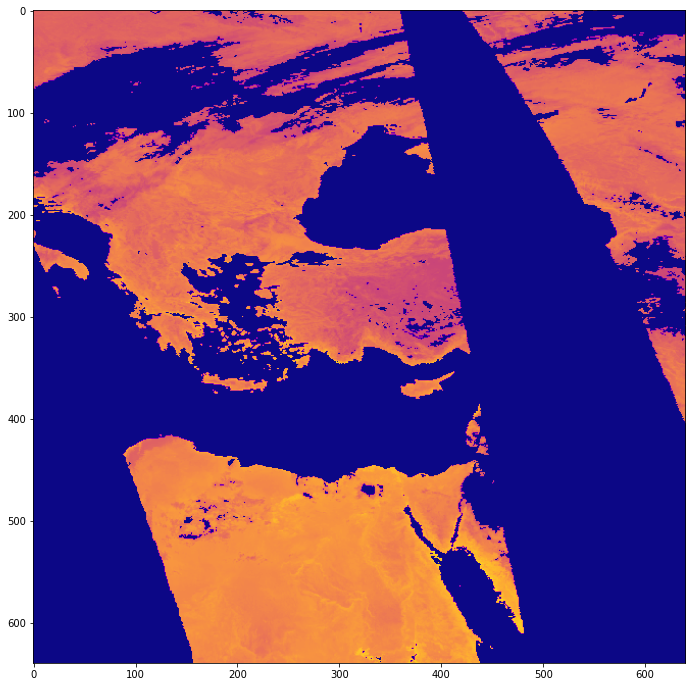

In [146]:
# Make a projection to discover the scale in degrees.
import io
from PIL import Image
proj = ee.Projection('EPSG:4326').atScale(5000).getInfo()

# Get scales out of the transform.
scale_x = proj['transform'][0]
scale_y = -proj['transform'][4]

# Makes a request for the image
request = {
    'assetId': 'JAXA/GCOM-C/L3/LAND/LST/V3/20230103A',
    'fileFormat': 'PNG',
    'bandIds': ['LST_AVE'],
    'grid': {
        'dimensions': {
            'width': 640,
            'height': 640
        },
        'affineTransform': {
            'scaleX': scale_x,
            'shearX': 0,
            'translateX': coords[0],
            'shearY': 0,
            'scaleY': scale_y,
            'translateY': coords[1]
        },
        'crsCode': proj['crs'],
    },
    'visualizationOptions': {'ranges': [{'min': 11651, 'max': 16459}]},
}

image_png = ee.data.getPixels(request)
# Do something with the image...

# Convert the byte array to an image
img = Image.open(io.BytesIO(image_png))

# Convert the image to grayscale
img = img.convert('L')

# Convert the image to a matrix
matrix = np.array(img)

# Plots the image
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='plasma')
plt.show()
